In [1]:
import csv
import cv2
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.layers import Cropping2D

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.layers import Dense, Activation, Flatten, Dropout, Lambda
from keras import optimizers

Using TensorFlow backend.


In [2]:
def getImage(source_path):
    filename = source_path.split('/')[-1]
    current_path = 'my_test_data/IMG/' + filename
    BGRImage = cv2.imread(current_path)
    return cv2.cvtColor(BGRImage, cv2.COLOR_BGR2RGB)

steering_correction = 0.25

In [3]:
def addRow(line, images, measurements):
    steering_center = float(line[3])
    
    #split between not steering and steering
    if(steering_center == 0):
        #no steering
        pUseImage = 0.75
        pIncludeSide = 0.85
        pFlipSide = 0.0
    else:
        #steering
        pUseImage = 1.0
        pIncludeSide = 0.65
        pFlipSide = 0.0
        
    #Include only a percentage of non-steering images
    if(np.random.rand()>(1.0-pUseImage)):
        measurements.append(steering_center)    
                
        center_image = getImage(line[0])
        images.append(center_image)
            
        flipped_steer_center = -steering_center
        measurements.append(flipped_steer_center)
            
        flipped_center_im = np.fliplr(center_image)
        images.append(flipped_center_im)
        
    #Percentage of side images to include
    if(np.random.rand()>(1.0-pIncludeSide)):
        left_image = getImage(line[1])
        right_image = getImage(line[2])

        images.append(left_image)
        images.append(right_image)

        steering_left = (steering_center + steering_correction)
        steering_right = (steering_center - steering_correction )        

        measurements.append(steering_left)
        measurements.append(steering_right)

        #Percentage of time to include flipped side image
        if(np.random.rand()>(1.0-pFlipSide)):
            flipped_left_im = np.fliplr(left_image)
            flipped_right_im = np.fliplr(right_image)

            images.append(flipped_left_im)
            images.append(flipped_right_im)

            flipped_steer_left = -steering_left
            flipped_steer_right = -steering_right

            measurements.append(flipped_steer_left)
            measurements.append(flipped_steer_right)

    #Percentage of left images to include
#    if(np.random.rand()>(1.0-pIncludeLeft)):
#        left_image = getImage(line[1])
#        images.append(left_image)

#        steering_left = (steering_center + steering_correction)
#        measurements.append(steering_left)
            
         #Percentage of time to include flipped side image
#        if(np.random.rand()>(1.0-pFlipSide)):
#            flipped_left_im = np.fliplr(left_image)

#            images.append(flipped_left_im)

#            flipped_steer_left = -steering_center + steering_correction

#            measurements.append(flipped_steer_left)
    #Percentage of right images to include
#    if(np.random.rand()>(1.0-pIncludeRight)):
#        right_image = getImage(line[2])
#        images.append(right_image)            
        
#        steering_right = (steering_center - steering_correction)
#        measurements.append(steering_right)
        #Percentage of time to include flipped side image
#        if(np.random.rand()>(1.0-pFlipSide)):
#            flipped_right_im = np.fliplr(right_image)
#            images.append(flipped_right_im)

#            flipped_steer_right = -steering_right - steering_correction
#            measurements.append(flipped_steer_right)

Number of images:  10894


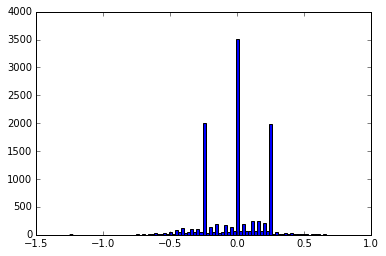

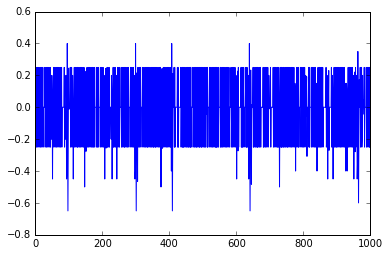

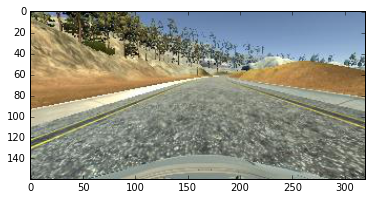

-0.0


In [4]:
#compiling data set without generator
lines = []
with open('my_test_data/driving_log.csv') as csvfile:
#with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

#print(lines[0])
lines=lines[1:]
#print(lines[0])
images = []
measurements = []

for line in lines:
    addRow(line, images, measurements)
            
X_train = np.array(images)
y_train = np.array(measurements)

print("Number of images: ",len(X_train))

plt.hist(y_train,bins=100)
plt.show()

plt.plot(y_train[0:1000])
plt.show()

plt.imshow(X_train[1])
plt.show()
print(y_train[1])

Sigma =  0.4166666666666667
8728


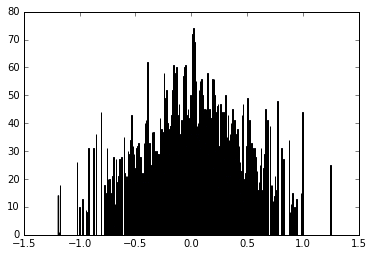

In [6]:
sigma = np.max(np.abs(y_train))/3
print("Sigma = ",sigma)

bufferFactor = 0.0001
normalImages=[]
normalSteering=[]

angles = np.random.normal(0,sigma,int(len(y_train)/3))

for angle in angles:
    choices = np.array(0)
    buffer = bufferFactor
    while(choices.size == 0 or choices.any() ==0):
        choices = np.where(np.logical_and(y_train>=(angle-buffer), y_train<=(angle+buffer)))[0]
        buffer+=bufferFactor
    
    pick = np.random.choice(choices)
    normalImages.append(X_train[pick])
    normalSteering.append(y_train[pick])
    
X_train_test = np.array(normalImages)
y_train_test = np.array(normalSteering)

print(len(y_train_test))
plt.hist(y_train_test,bins=500)
plt.show()


Number of images:  25944


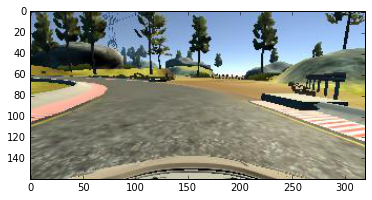

0.0


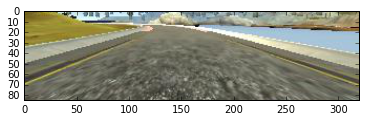

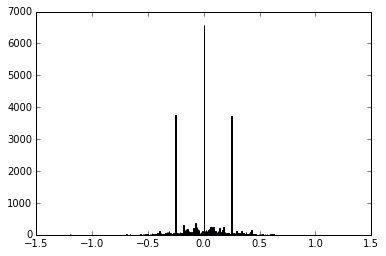

[ 0.25 -0.25  0.  ]


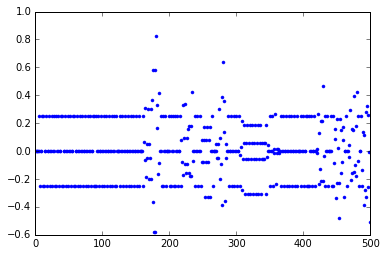

In [6]:
#View Data
print("Number of images: ",len(X_train))

plt.imshow(X_train[4])
plt.show()
print(y_train[4])

image = X_train[5000]
TestImage = image/255
(y,x,z) = TestImage.shape

TestImage = TestImage[50:y-25,0:x]
#Check Preprocessing
plt.imshow(TestImage)
plt.show()

plt.hist(y_train,bins=500)
plt.show()

(values,counts)=np.unique(y_train, return_counts=True)
ind=counts.argsort()[-3:]

print(values[ind])

plt.plot(y_train[0:500],'.')
plt.show()

Number of train_samples =  6428 Number of Validation =  1608


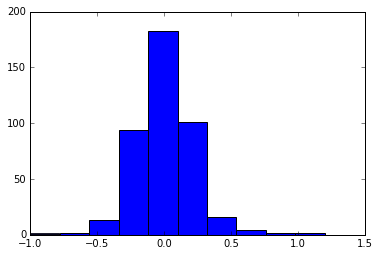

In [7]:
#Generator just taking random samples from data set
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            
            for batch_sample in batch_samples:
                addRow(batch_sample,images,angles)
            
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

print("Number of train_samples = ", len(train_samples), "Number of Validation = ", len(validation_samples))
x_train_gen, y_train_gen = (next(train_generator))
plt.hist(y_train_gen)
plt.show()

In [8]:
input = Input(shape=(160, 320, 3))

preProcess1 = Lambda(lambda x: x/255.0 - 0.5)(input)
#preProcess1 = Lambda(lambda x: x/127.5 -1.)(input)

crop1 = Cropping2D(cropping=((50,25),(0,0)), input_shape = (1,160,320))(preProcess1)

conv1 = Convolution2D(64, (7, 7), strides=2)(crop1)
conv1 = MaxPooling2D(pool_size=(3,3), strides=2)(conv1)

conv2 = Convolution2D(192, (3, 3), activation = 'linear', strides=1)(conv1)
conv2 = MaxPooling2D(pool_size=(3, 3), strides=2)(conv2)

#Incesption Layer
Inception1Conv1 = Convolution2D(64, (1, 1), padding='same', activation='linear')(conv2)
Inception1Conv2 = Convolution2D(128, (3, 3), padding='same', activation='linear')(conv2)
Inception1Conv3 = Convolution2D(32, (5, 5), padding='same', activation='linear')(conv2)
Inception1MP = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(conv2)

Inception1 = concatenate([Inception1Conv1, Inception1Conv2, Inception1Conv3, Inception1MP], axis=3)

drop1 = Dropout(0.4)(Inception1)
act1 = Activation('linear')(drop1)
Flat1=Flatten()(act1)

FCL2 = Dense(10, activation='elu')(Flat1)

output=Dense(1)(FCL2)

model = Model(inputs = input, outputs = output)
sgd = optimizers.SGD(lr=0.00000001, decay=1e-6)
model.compile(loss='mse', optimizer='sgd')
model.fit(X_train, y_train, validation_split = 0.2, shuffle=True, epochs = 10)
#model.fit_generator(train_generator, steps_per_epoch=len(train_samples),
#          validation_data=validation_generator, validation_steps=len(validation_samples), epochs=2)

model.summary()

model.save('model.h5')
print("SAVED MODEL")



Train on 8715 samples, validate on 2179 samples
Epoch 1/10
8715/8715 [==============================] - 13s 1ms/step - loss: 0.1515 - val_loss: 0.0424
Epoch 2/10
8715/8715 [==============================] - 12s 1ms/step - loss: 0.0324 - val_loss: 0.0408
Epoch 3/10
8715/8715 [==============================] - 12s 1ms/step - loss: 0.0270 - val_loss: 0.0314
Epoch 4/10
8715/8715 [==============================] - 12s 1ms/step - loss: 0.0252 - val_loss: 0.0295
Epoch 5/10
8715/8715 [==============================] - 12s 1ms/step - loss: 0.0237 - val_loss: 0.0299
Epoch 6/10
8715/8715 [==============================] - 13s 1ms/step - loss: 0.0227 - val_loss: 0.0304
Epoch 7/10
8715/8715 [==============================] - 16s 2ms/step - loss: 0.0221 - val_loss: 0.0287
Epoch 8/10
8715/8715 [==============================] - 17s 2ms/step - loss: 0.0213 - val_loss: 0.0268
Epoch 9/10
8715/8715 [==============================] - 16s 2ms/step - loss: 0.0209 - val_loss: 0.0317
Epoch 10/10
8715/8715 [==